In [1]:
# !pip install tensorflow

# !pip install keras



# import tensorflow as tf

# from tensorflow.keras.applications import VGG19

# from tensorflow.keras.layers import Dense, Flatten, Dropout

# from tensorflow.keras.models import Model

# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from sklearn.model_selection import train_test_split

# import os



import tensorflow as tf

from tensorflow.keras import models, layers

import numpy as np

import matplotlib.pyplot as plt

from IPython.display import HTML

from tensorflow.keras.callbacks import EarlyStopping

In [2]:
BATCH_SIZE = 16

IMAGE_SIZE = (256,256)

# Create Dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    "/kaggle/input/augmented/augmented_data",

    
    batch_size = BATCH_SIZE,

    image_size = IMAGE_SIZE,

    shuffle = True,

    seed = 24

)

Found 12342 files belonging to 10 classes.


# Extract and print class names

In [4]:
class_names = dataset.class_names

class_names

['DG0', 'DG1', 'DG10', 'DG11', 'DG12', 'DG13', 'DG2', 'DG3', 'DG8', 'DG9']

In [5]:
for image_batch, label_batch in dataset.take(1):

    print(image_batch.shape)

    print(label_batch.numpy())

(16, 256, 256, 3)
[0 0 8 0 0 8 0 7 0 9 0 2 3 9 3 7]


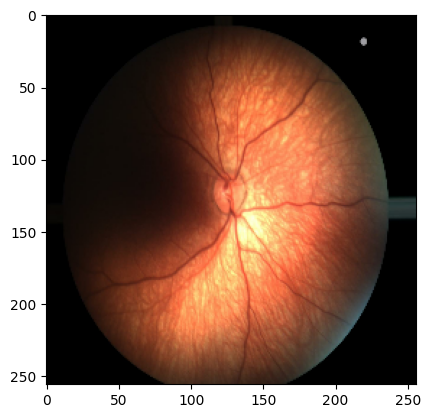

In [6]:
for image_batch, label_batch in dataset.take(1):

    plt.imshow(image_batch[0].numpy().astype("uint8"))

    plt.show

# Split Dataset Into Training Dataset and Test Dataset

In [7]:
def get_partitioned_datasets(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

        if shuffle:

            dataset = dataset.shuffle(shuffle_size, seed=10)



        dataset_len = len(dataset)



        train_len = int(train_split*dataset_len)

        train_dataset = dataset.take(train_len)

        dataset = dataset.skip(train_len)



        val_len = int(val_split*dataset_len)

        val_dataset = dataset.take(val_len)

        dataset = dataset.skip(val_len)



        test_len = dataset_len - train_len - val_len

        test_dataset = dataset.take(test_len)



        return train_dataset, val_dataset, test_dataset

In [8]:
train_dataset, val_dataset, test_dataset = get_partitioned_datasets(dataset)

In [9]:
len(train_dataset)

617

In [10]:
len(val_dataset)

77

In [11]:
len(test_dataset)

78

In [12]:
train_dataset = train_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_dataset = test_dataset.shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
ONE_IMAGE_SIZE = 256

In [14]:
resize_and_rescale = tf.keras.Sequential([

    layers.Resizing(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE),

    layers.Rescaling(1.0/255)

])

In [15]:
data_augmentation = tf.keras.Sequential([

    layers.RandomFlip("horizontal_and_vertical"),

    layers.RandomRotation(0.2),

    layers.RandomZoom(0.2),

    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),

    layers.RandomContrast(0.2),

    layers.RandomBrightness(0.2)

])

# Create CNN Model

In [22]:
CHANNELS = 3

input_shape = (BATCH_SIZE, ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)

n_classes = len(class_names)



model = models.Sequential([

    layers.Input(shape=(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)),  # Input shape

    layers.Resizing(ONE_IMAGE_SIZE, ONE_IMAGE_SIZE),  # Resize images

    layers.Rescaling(1.0 / 255),  # Normalize pixel values

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dense(n_classes, activation='softmax'),

])



# Print Model Summary

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,778 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

# Compile and Train the Model

In [23]:
model.compile(

    optimizer='adam',

    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),

    metrics=['accuracy']

)

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(

    train_dataset,

    batch_size=BATCH_SIZE,

    validation_data=val_dataset,

    verbose=1,

    epochs=30,

    callbacks=[early_stopping]

)

Epoch 1/30


I0000 00:00:1733061722.711147     100 service.cc:145] XLA service 0x7ca50400c150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733061722.711220     100 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 13/617 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.2635 - loss: 2.0563      

I0000 00:00:1733061726.273051     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


265/617 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4184 - loss: 1.7475

I0000 00:00:1733061731.672671     101 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 68 bytes spill stores, 68 bytes spill loads



617/617 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - accuracy: 0.4428 - loss: 1.6552 - val_accuracy: 0.5024 - val_loss: 1.4237
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.5163 - loss: 1.3894 - val_accuracy: 0.5568 - val_loss: 1.2894
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.5623 - loss: 1.2578 - val_accuracy: 0.5990 - val_loss: 1.1270
Epoch 4/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.5817 - loss: 1.1521 - val_accuracy: 0.6047 - val_loss: 1.0420
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 42ms/step - accuracy: 0.6230 - loss: 1.0457 - val_accuracy: 0.6656 - val_loss: 0.9358
Epoch 6/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.6599 - loss: 0.9444 - val_accuracy: 0.6786 - val_loss: 0.8262
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.6896 - loss: 0.8296 - val_accuracy: 0.7386 - val_loss: 0.6948
Epoch 8/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.7344 - loss: 0.7144 - val_accurac

# Plot Graphs to Visualize Model's Performance

## Training and Validation Loss

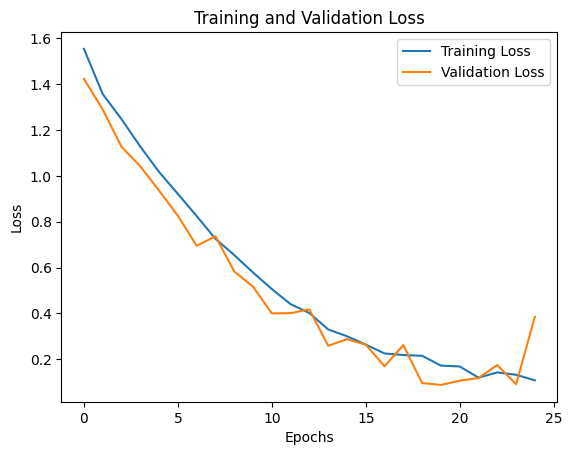

In [25]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Training and Validation Accuracy

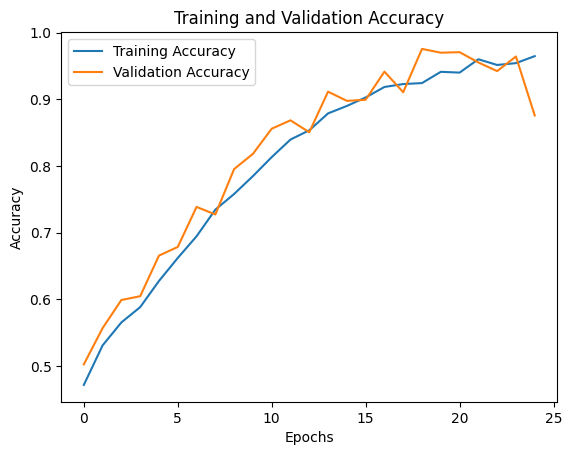

In [26]:
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

## Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━

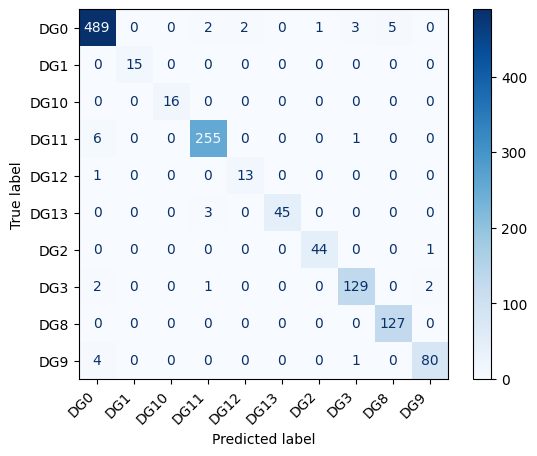

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the true labels and predictions from the test dataset
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.show()

## Class Distributions for Dataset

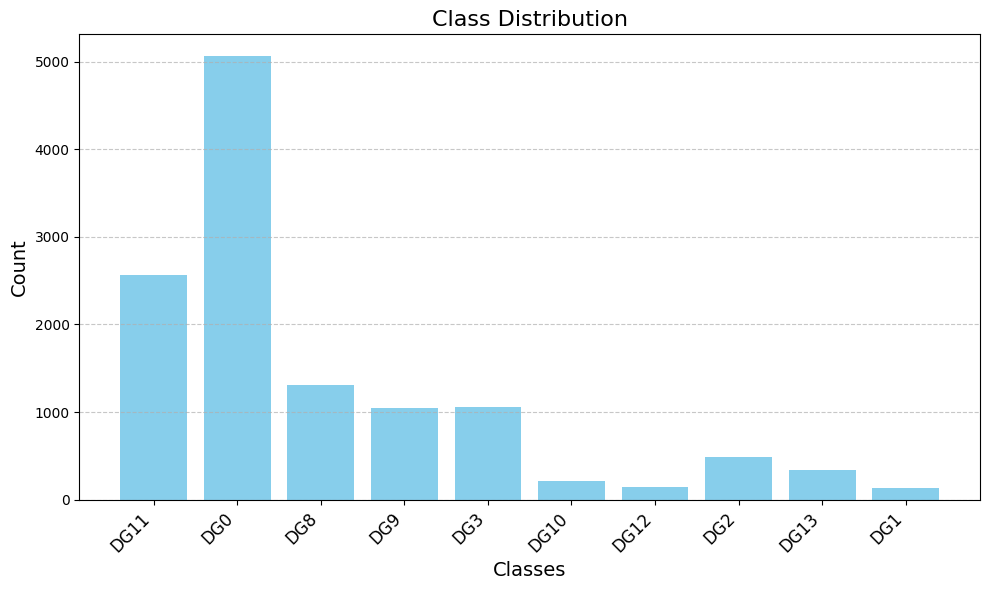

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

# Count class labels
class_counts = Counter()

for _, labels in dataset:
    class_counts.update(labels.numpy())

# Map class indices to names
class_distribution = {class_names[i]: count for i, count in class_counts.items()}

# Plot the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')

# Customize the plot
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

# Load the Saved Model

In [34]:
# Save your model to a file
model_save_path = '/kaggle/working/new/my_model.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/new/my_model.h5


In [36]:
from tensorflow.keras.models import load_model

# Replace the path with the actual path to the uploaded file
model_path = '/kaggle/working/new/my_model.h5'  # Update this with your file path
loaded_model = load_model(model_path)

# Check the model summary to ensure it was loaded successfully
loaded_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,780 (3.42 MB)

 Trainable params: 896,778 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [37]:
test_loss, test_acc = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9767 - loss: 0.0768
Test Loss: 0.08
Test Accuracy: 97.44%


In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
from tensorflow.keras.models import load_model
from collections import Counter

# Load the model
model_path = '/kaggle/working/new/my_model.h5'  # Update this with your file path
loaded_model = load_model(model_path)

# Evaluate the model on the test dataset (assuming test_dataset is available)
test_loss, test_acc = loaded_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# Get the model predictions on the test set
test_predictions = loaded_model.predict(test_dataset)
test_labels = np.argmax(test_dataset.labels, axis=1)  # Assuming your dataset has labels

# Convert predictions to class labels
predicted_classes = np.argmax(test_predictions, axis=1)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(test_labels), yticklabels=np.unique(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Plot the test accuracy and loss over the epochs
# Assuming you have access to the model's training history (from model.fit())
history = loaded_model.history.history  # This contains the training history
if 'accuracy' in history and 'loss' in history:
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Test Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss', color='blue')
    plt.plot(history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Test Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Training history is not available to plot accuracy and loss graphs.")


78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.9737 - loss: 0.0758
Test Loss: 0.08
Test Accuracy: 97.58%
78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step


AttributeError: '_PrefetchDataset' object has no attribute 'labels'

# ResNet

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 128, 128,  │      4,736 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_52[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 64, 64,    │      1,056 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 64, 64,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 64, 64,    │      4,224 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 64, 64,    │      4,224 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 64, 64,    │          0 │ add_12[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 64, 64,    │      4,128 │ re_lu_12[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        128 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 64, 64,    │      9,248 │ batch_normalizat

 Total params: 1,011,979 (3.86 MB)

 Trainable params: 1,004,747 (3.83 MB)

 Non-trainable params: 7,232 (28.25 KB)

Epoch 1/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 75s 66ms/step - accuracy: 0.4173 - loss: 1.7748 - val_accuracy: 0.5308 - val_loss: 1.3318
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5312 - loss: 1.3735 - val_accuracy: 0.5844 - val_loss: 1.1619
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 52ms/step - accuracy: 0.5477 - loss: 1.2849 - val_accuracy: 0.5901 - val_loss: 1.1709
Epoch 4/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5754 - loss: 1.2124 - val_accuracy: 0.6144 - val_loss: 1.0634
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.5908 - loss: 1.1575 - val_accuracy: 0.6185 - val_loss: 1.0657
Epoch 6/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.6113 - loss: 1.1077 - val_accuracy: 0.6607 - val_loss: 0.9068
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 49s 52ms/step - accuracy: 0.6368 - loss: 1.0373 - val_accuracy: 0.6640 - val_loss: 0.9477
Epoch 8/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.6622 - loss: 0.9610 - 

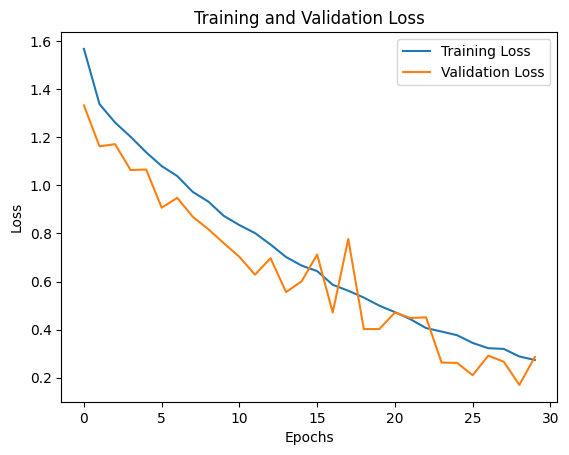

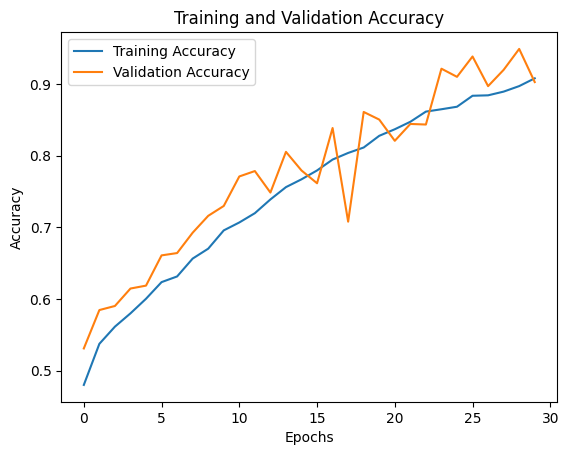

In [58]:
from tensorflow.keras import layers, models
import tensorflow as tf

CHANNELS = 3
n_classes = 11
ONE_IMAGE_SIZE = 256

# Define a bottleneck ResNet block with fewer filters
def bottleneck_block(x, filters, stride=1):
    shortcut = x

    # 1x1 Convolution for dimension reduction
    x = layers.Conv2D(filters, kernel_size=(1, 1), strides=stride, padding="same", activation="relu", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # 3x3 Convolution
    x = layers.Conv2D(filters, kernel_size=(3, 3), strides=1, padding="same", activation="relu", kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # 1x1 Convolution for dimension restoration
    x = layers.Conv2D(filters * 4, kernel_size=(1, 1), strides=1, padding="same", activation=None, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut dimensions if needed
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = layers.Conv2D(filters * 4, kernel_size=(1, 1), strides=stride, padding="same", kernel_initializer='he_normal')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Add shortcut and apply activation
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# Define a block group for stacking multiple blocks
def block_group(x, filters, num_blocks, stride=1):
    # First block with stride
    x = bottleneck_block(x, filters, stride)

    # Remaining blocks
    for _ in range(1, num_blocks):
        x = bottleneck_block(x, filters)
    return x

# Define the ResNet-like architecture with fewer parameters
def build_resnet(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, kernel_size=(7, 7), strides=2, padding="same", activation="relu", kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)

    # ResNet Blocks (reduced filters and number of blocks)
    x = block_group(x, filters=32, num_blocks=2, stride=1)   # Stage 1
    x = block_group(x, filters=64, num_blocks=2, stride=2)  # Stage 2
    x = block_group(x, filters=128, num_blocks=2, stride=2)  # Stage 3

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D()(x)

    # Fully Connected Layer
    x = layers.Dense(256, activation='relu', kernel_initializer='he_normal')(x)
    x = layers.Dropout(0.5)(x)  # Adding Dropout to prevent overfitting

    outputs = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Define input shape and build the model
input_shape = (ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
resnet_model = build_resnet(input_shape, n_classes)

# Print Model Summary
resnet_model.summary()

# Compile the model
resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Fine-tune the learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Fit the model
history = resnet_model.fit(
    train_dataset,
    batch_size=16,
    validation_data=val_dataset,
    epochs=30,
    verbose=1,
    callbacks=[early_stopping]
)

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━

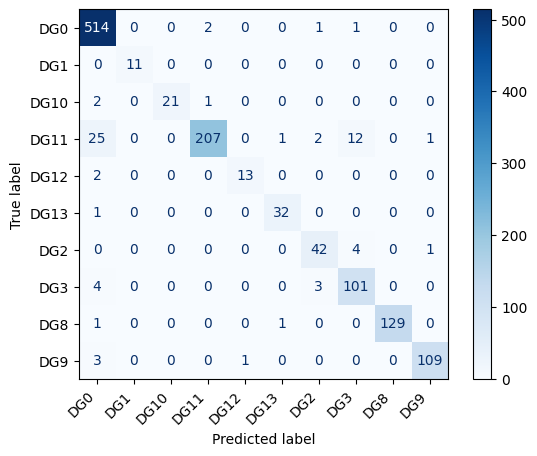

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the true labels and predictions from the test dataset
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    predictions = resnet_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.show()

In [60]:
resnet_model.save("/kaggle/working/new2/resnet_model.h5")

In [61]:
import json

# Save history to a JSON file
with open('/kaggle/working/new2/history.json', 'w') as f:
    json.dump(history.history, f)

In [62]:
test_loss, test_acc = resnet_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9534 - loss: 0.1454
Test Loss: 0.14
Test Accuracy: 95.35%


# EfficientNet

In [16]:
from tensorflow.keras import layers, models

# Define constants
CHANNELS = 3
input_shape = (ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

def conv_block(inputs, filters, kernel_size, strides=1, activation='swish'):
    """
    A basic convolutional block with Batch Normalization and Swish activation.
    """
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    return x

def squeeze_and_excite_block(inputs, reduction_ratio=4):
    """
    Implements the Squeeze-and-Excite block.
    """
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // reduction_ratio, activation="relu")(se)
    se = layers.Dense(filters, activation="sigmoid")(se)
    return layers.Multiply()([inputs, se])

def mbconv_block(inputs, filters, kernel_size, strides, expansion_factor=6, reduction_ratio=4):
    """
    Implements an MBConv block, the core building block of EfficientNet.
    """
    input_channels = inputs.shape[-1]
    expanded = layers.Conv2D(input_channels * expansion_factor, 1, padding="same")(inputs)
    expanded = layers.BatchNormalization()(expanded)
    expanded = layers.Activation("swish")(expanded)

    depthwise = layers.DepthwiseConv2D(kernel_size, strides=strides, padding="same")(expanded)
    depthwise = layers.BatchNormalization()(depthwise)
    depthwise = layers.Activation("swish")(depthwise)

    se = squeeze_and_excite_block(depthwise, reduction_ratio)

    output = layers.Conv2D(filters, 1, padding="same")(se)
    output = layers.BatchNormalization()(output)

    if strides == 1 and input_channels == filters:
        output = layers.Add()([inputs, output])  # Residual connection
    return output

def efficient_net_like(input_shape, n_classes):
    """
    Builds an EfficientNet-like model from scratch.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)  # Normalize pixel values

    # Initial Conv Block
    x = conv_block(x, filters=32, kernel_size=3, strides=2)

    # MBConv blocks
    x = mbconv_block(x, filters=16, kernel_size=3, strides=1)
    x = mbconv_block(x, filters=24, kernel_size=3, strides=2)
    x = mbconv_block(x, filters=40, kernel_size=5, strides=2)
    x = mbconv_block(x, filters=80, kernel_size=3, strides=2)
    x = mbconv_block(x, filters=112, kernel_size=5, strides=1)
    x = mbconv_block(x, filters=192, kernel_size=5, strides=2)
    x = mbconv_block(x, filters=320, kernel_size=3, strides=1)

    # Final layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Create the model
model = efficient_net_like(input_shape, n_classes)

# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ rescaling_1[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      6,336 │ activation[0][0]  │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        768 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ depthwise_conv2d    │ (None, 128, 128,  │      1,920 │ activation_1[0][… │
│ (DepthwiseConv2D)   │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        768 │ depthwise_conv2d… │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 192)       │          0 │ activation_2[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 48)        │      9,264 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 192)       │      9,408 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ activation_2[0][… │
│                     │ 192)              │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      3,088 │ multiply[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,093,250 (7.99 MB)

 Trainable params: 2,079,714 (7.93 MB)

 Non-trainable params: 13,536 (52.88 KB)

In [17]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,
    validation_data=val_dataset
)

Epoch 1/30


I0000 00:00:1733306203.057075     105 service.cc:145] XLA service 0x7d9cec0031b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733306203.057132     105 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/617 ━━━━━━━━━━━━━━━━━━━━ 43s 72ms/step - accuracy: 0.0469 - loss: 2.5173        

I0000 00:00:1733306251.307626     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


617/617 ━━━━━━━━━━━━━━━━━━━━ 176s 131ms/step - accuracy: 0.4407 - loss: 1.7696 - val_accuracy: 0.4099 - val_loss: 1.7836
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 91ms/step - accuracy: 0.5366 - loss: 1.3366 - val_accuracy: 0.3701 - val_loss: 2.6977
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.5927 - loss: 1.1888 - val_accuracy: 0.5041 - val_loss: 1.5716
Epoch 4/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.6410 - loss: 1.0313 - val_accuracy: 0.5828 - val_loss: 1.2589
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.6781 - loss: 0.9092 - val_accuracy: 0.5950 - val_loss: 1.3486
Epoch 6/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 74s 93ms/step - accuracy: 0.7208 - loss: 0.8001 - val_accuracy: 0.5430 - val_loss: 1.4884
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.7581 - loss: 0.6993 - val_accuracy: 0.7232 - val_loss: 0.8173
Epoch 8/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 73s 93ms/step - accuracy: 0.7879 - loss: 0.6152 - val_accur

In [18]:
# Save the trained model
model_save_path = '/kaggle/working/new3/efficientnet_model.h5'
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

Model saved at /kaggle/working/new3/efficientnet_model.h5


In [19]:
import json

# Save training history to a JSON file
history_path = '/kaggle/working/new3/efficientnet_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"Training history saved at {history_path}")


Training history saved at /kaggle/working/new3/efficientnet_history.json


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.9614 - loss: 0.1136
Test Loss: 0.10
Test Accuracy: 96.79%


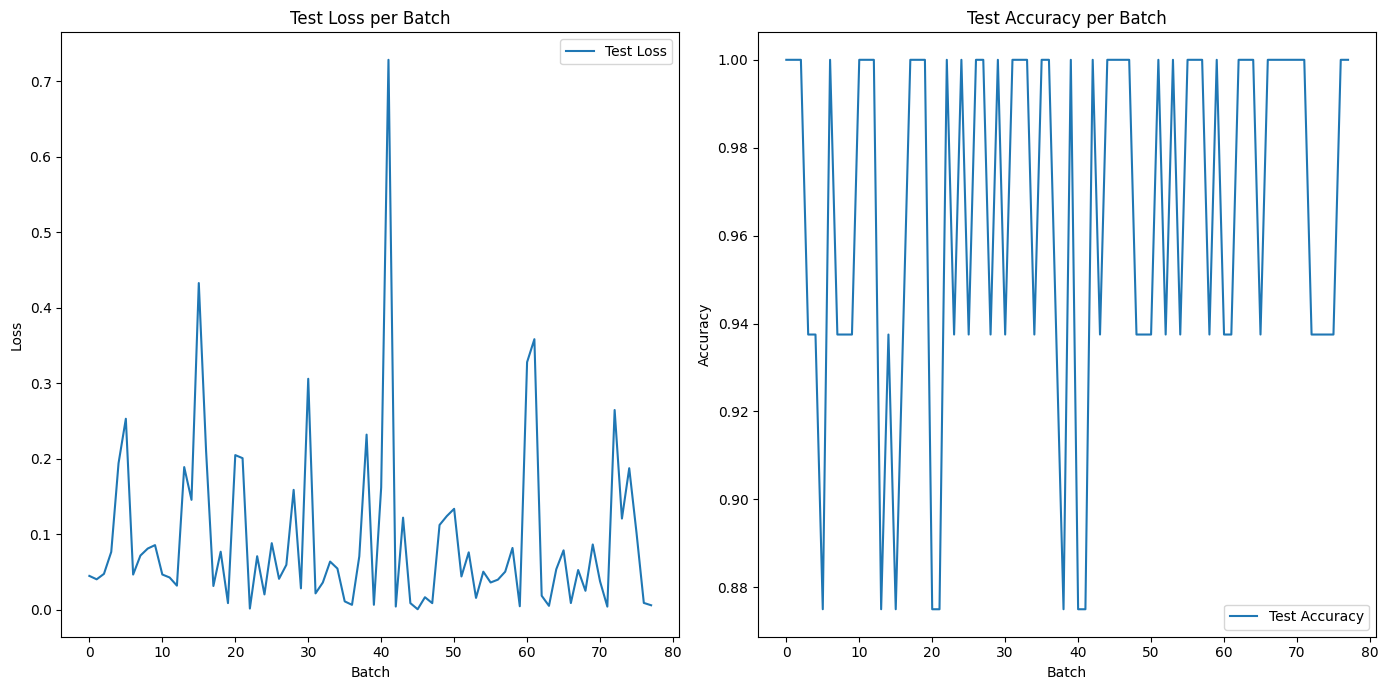

In [21]:
# Initialize lists to store loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Loop through the test dataset and evaluate on each batch
for images, labels in test_dataset:
    # Compute loss and accuracy for the current batch
    batch_loss, batch_accuracy = model.evaluate(images, labels, verbose=0)
    test_losses.append(batch_loss)
    test_accuracies.append(batch_accuracy)

# Plot test loss and accuracy
batches = range(len(test_losses))

plt.figure(figsize=(14, 7))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(batches, test_losses, label='Test Loss')
plt.title('Test Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(batches, test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

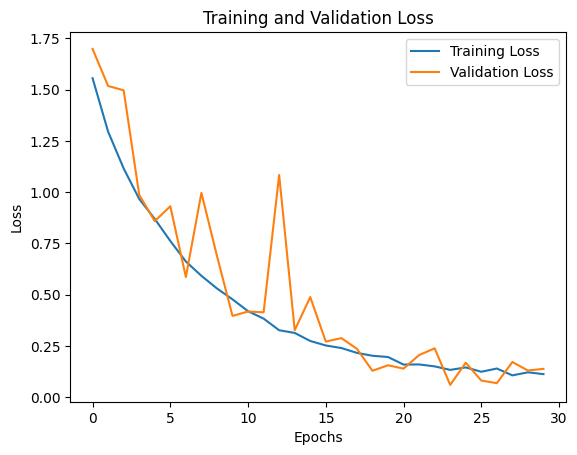

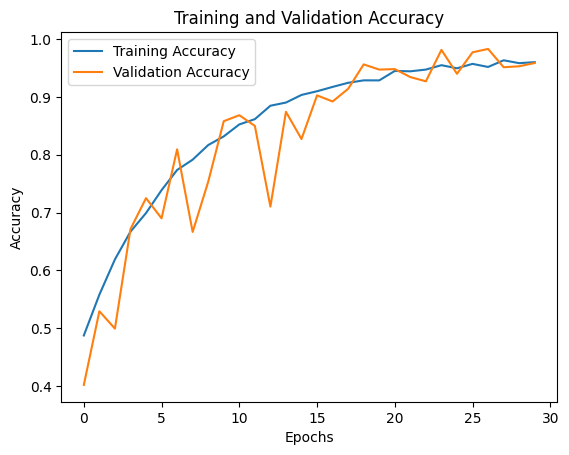

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━

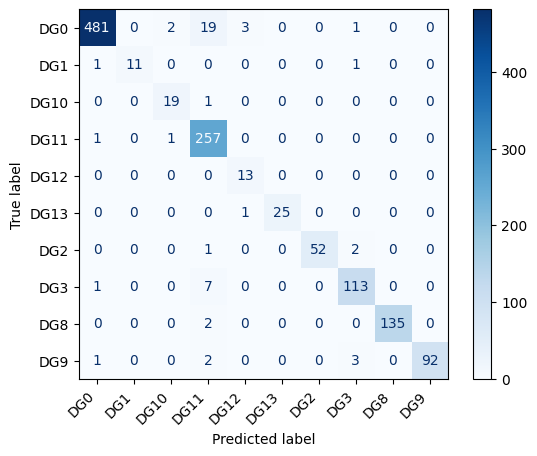

In [24]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Get the true labels and predictions from the test dataset
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    true_labels.extend(labels.numpy())
    predictions = model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")
plt.show()

# InceptionV3

In [22]:
from tensorflow.keras import layers, models

# Define constants
CHANNELS = 3
input_shape = (ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

def inception_block(inputs, filters_1x1, filters_3x3_reduce, filters_3x3, 
                    filters_5x5_reduce, filters_5x5, filters_pool_proj):
    """
    Implements an Inception block.
    """
    # 1x1 Convolution
    conv_1x1 = layers.Conv2D(filters_1x1, (1, 1), padding='same', activation='relu')(inputs)

    # 1x1 Convolution -> 3x3 Convolution
    conv_3x3 = layers.Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_3x3 = layers.Conv2D(filters_3x3, (3, 3), padding='same', activation='relu')(conv_3x3)

    # 1x1 Convolution -> 5x5 Convolution
    conv_5x5 = layers.Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu')(inputs)
    conv_5x5 = layers.Conv2D(filters_5x5, (5, 5), padding='same', activation='relu')(conv_5x5)

    # 3x3 MaxPooling -> 1x1 Convolution
    pool_proj = layers.MaxPooling2D((3, 3), strides=(1, 1), padding='same')(inputs)
    pool_proj = layers.Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu')(pool_proj)

    # Concatenate all filters
    output = layers.concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1)
    return output

def inception_net_like(input_shape, n_classes):
    """
    Builds an Inception-like model from scratch.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)  # Normalize pixel values

    # Initial Conv and Pooling layers
    x = layers.Conv2D(64, (7, 7), strides=2, padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # Inception blocks
    x = inception_block(x, 64, 96, 128, 16, 32, 32)
    x = inception_block(x, 128, 128, 192, 32, 96, 64)

    # Intermediate pooling layer
    x = layers.MaxPooling2D((3, 3), strides=2, padding="same")(x)

    # More Inception blocks
    x = inception_block(x, 192, 96, 208, 16, 48, 64)
    x = inception_block(x, 160, 112, 224, 24, 64, 64)
    x = inception_block(x, 128, 128, 256, 24, 64, 64)
    x = inception_block(x, 112, 144, 288, 32, 64, 64)
    x = inception_block(x, 256, 160, 320, 32, 128, 128)

    # Final pooling and classification layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Create the model
model = inception_net_like(input_shape, n_classes)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Train the model
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=30,  # You can adjust the epochs
    validation_data=val_dataset
)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      9,472 │ rescaling_2[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │      6,240 │ max_pooling2d[0]… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │      1,040 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │      4,160 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    110,720 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     12,832 │ conv2d_19[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │      2,080 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_16[0][0],  │
│ (Concatenate)       │ 256)              │            │ conv2d_18[0][0],  │
│                     │                   │            │ conv2d_20[0][0],  │
│                     │                   │            │ conv2d_21[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 64, 64,    │      8,224 │ concatenate[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ concatenate[0][0] │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │     32,896 │ concatenate[0][0] │
│                     │ 128)              │            │                 

 Total params: 3,352,778 (12.79 MB)

 Trainable params: 3,352,778 (12.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
  1/617 ━━━━━━━━━━━━━━━━━━━━ 8:49:53 52s/step - accuracy: 0.0000e+00 - loss: 2.3092

I0000 00:00:1733308871.089124     103 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



405/617 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - accuracy: 0.3982 - loss: 1.7658

I0000 00:00:1733308917.420490     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_4', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_19', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads



617/617 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - accuracy: 0.4055 - loss: 1.7335 - val_accuracy: 0.4497 - val_loss: 1.5514
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 86s 112ms/step - accuracy: 0.4762 - loss: 1.5200 - val_accuracy: 0.4927 - val_loss: 1.4598
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 85s 111ms/step - accuracy: 0.4914 - loss: 1.4668 - val_accuracy: 0.5000 - val_loss: 1.4684
Epoch 4/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 85s 110ms/step - accuracy: 0.5055 - loss: 1.4655 - val_accuracy: 0.5373 - val_loss: 1.3978
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 85s 110ms/step - accuracy: 0.5167 - loss: 1.4281 - val_accuracy: 0.5235 - val_loss: 1.3702
Epoch 6/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 84s 109ms/step - accuracy: 0.5413 - loss: 1.3647 - val_accuracy: 0.5414 - val_loss: 1.3348
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 85s 111ms/step - accuracy: 0.5360 - loss: 1.3623 - val_accuracy: 0.5657 - val_loss: 1.2716
Epoch 8/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 87s 112ms/step - accuracy: 0.5414 - loss: 1.3293 - va

In [23]:
# Save the trained InceptionV3 model
model_save_path = '/kaggle/working/new4/inceptionv3_model.h5'
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# Save training history to a JSON file
import json
history_path = '/kaggle/working/new4/inceptionv3_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"Training history saved at {history_path}")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Model saved at /kaggle/working/new4/inceptionv3_model.h5
Training history saved at /kaggle/working/new4/inceptionv3_history.json
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 26ms/step - accuracy: 0.8717 - loss: 0.3255
Test Loss: 0.34
Test Accuracy: 87.02%


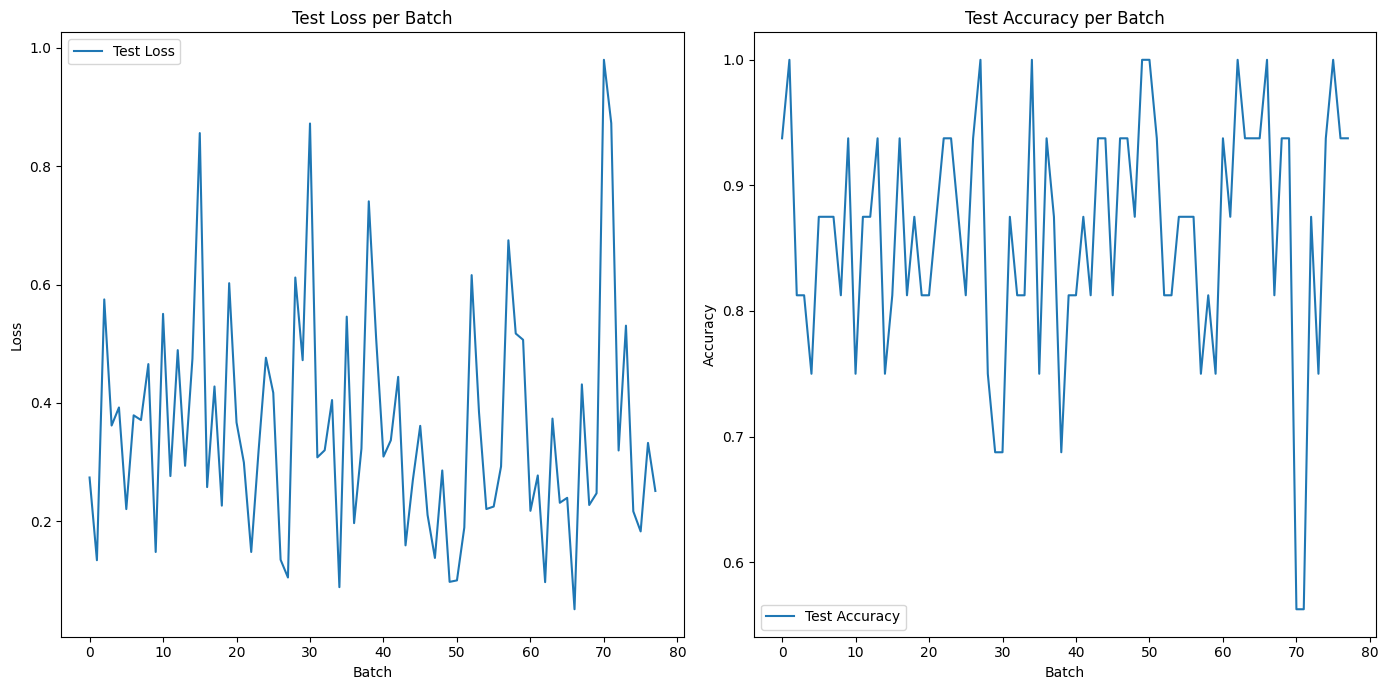

In [24]:
# Initialize lists to store loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Loop through the test dataset and evaluate on each batch
for images, labels in test_dataset:
    # Compute loss and accuracy for the current batch
    batch_loss, batch_accuracy = model.evaluate(images, labels, verbose=0)
    test_losses.append(batch_loss)
    test_accuracies.append(batch_accuracy)

# Plot test loss and accuracy
batches = range(len(test_losses))

plt.figure(figsize=(14, 7))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(batches, test_losses, label='Test Loss')
plt.title('Test Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(batches, test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

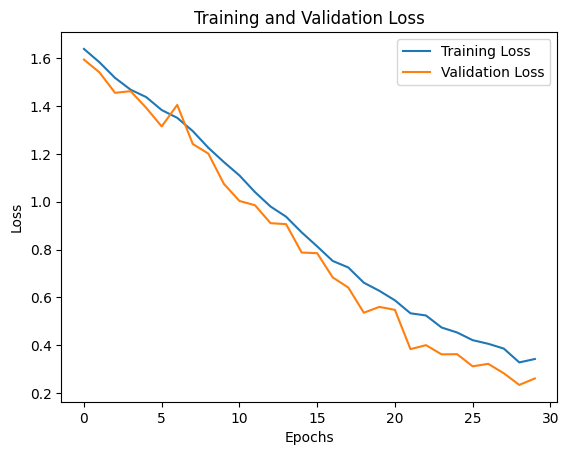

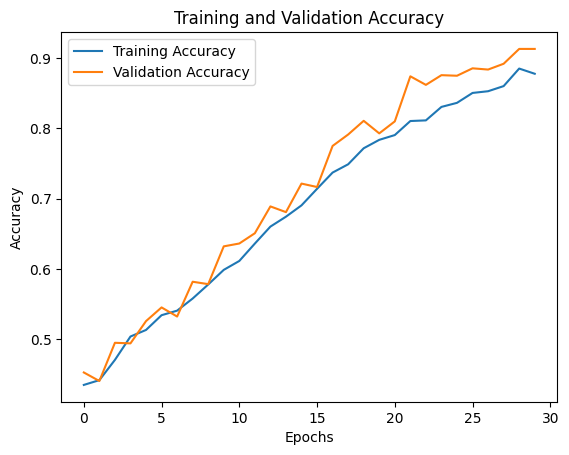

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━

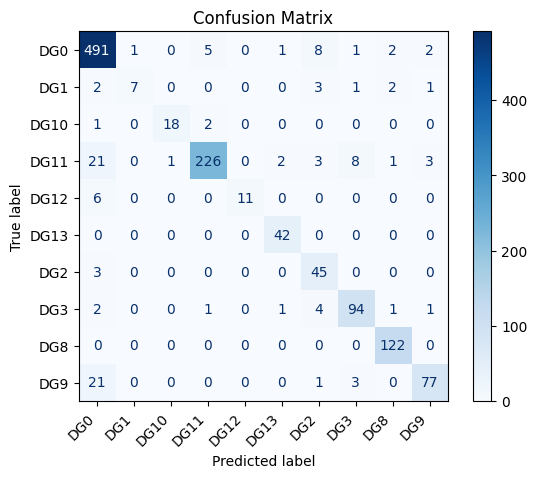

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset to get predictions and true labels
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')  # Normalized matrix

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix")
plt.show()


# VGG19

In [25]:
from tensorflow.keras import layers, models

# Define constants
CHANNELS = 3
input_shape = (ONE_IMAGE_SIZE, ONE_IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

def vgg19_block(inputs, num_convs, filters):
    """
    Implements a reduced VGG19 block with specified number of convolutional layers.
    """
    x = inputs
    for _ in range(num_convs):
        x = layers.Conv2D(filters, (3, 3), padding="same", activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    return x

def reduced_vgg19_like(input_shape, n_classes):
    """
    Builds a reduced VGG19-like model with ~1M parameters.
    """
    inputs = layers.Input(shape=input_shape)
    x = layers.Rescaling(1.0 / 255)(inputs)  # Normalize pixel values

    # Reduced VGG19 Blocks
    x = vgg19_block(x, num_convs=1, filters=32)   # Block 1: 1 conv layer
    x = vgg19_block(x, num_convs=1, filters=64)   # Block 2: 1 conv layer
    x = vgg19_block(x, num_convs=2, filters=128)  # Block 3: 2 conv layers
    x = vgg19_block(x, num_convs=2, filters=256)  # Block 4: 2 conv layers

    # Final pooling and fully connected layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation="relu")(x)  # Reduced fully connected layer
    x = layers.Dropout(0.4)(x)  # Dropout to avoid overfitting
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    return models.Model(inputs, outputs)

# Create the reduced VGG19-like model
model = reduced_vgg19_like(input_shape, n_classes)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

# Define early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    verbose=1,
    epochs=30,
    callbacks=[early_stopping]
)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,160,266 (4.43 MB)

 Trainable params: 1,160,266 (4.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
  7/617 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.2253 - loss: 2.1639 

I0000 00:00:1733311964.919068     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads



467/617 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.3950 - loss: 1.8103

I0000 00:00:1733311978.918955     105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_2', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_1', 4 bytes spill stores, 12 bytes spill loads



617/617 ━━━━━━━━━━━━━━━━━━━━ 58s 57ms/step - accuracy: 0.4000 - loss: 1.7840 - val_accuracy: 0.4545 - val_loss: 1.5646
Epoch 2/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 48s 51ms/step - accuracy: 0.4627 - loss: 1.5678 - val_accuracy: 0.4771 - val_loss: 1.4986
Epoch 3/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.4994 - loss: 1.4740 - val_accuracy: 0.4927 - val_loss: 1.4679
Epoch 4/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.5065 - loss: 1.4461 - val_accuracy: 0.5649 - val_loss: 1.3331
Epoch 5/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.5257 - loss: 1.3811 - val_accuracy: 0.5414 - val_loss: 1.3225
Epoch 6/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 51ms/step - accuracy: 0.5277 - loss: 1.3718 - val_accuracy: 0.5368 - val_loss: 1.3527
Epoch 7/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.5361 - loss: 1.3388 - val_accuracy: 0.5434 - val_loss: 1.3000
Epoch 8/30
617/617 ━━━━━━━━━━━━━━━━━━━━ 47s 50ms/step - accuracy: 0.5383 - loss: 1.3116 - val_accurac

In [26]:
# Save the trained VGG19-like model
model_save_path = '/kaggle/working/new5/vgg19_model.h5'
model.save(model_save_path)
print(f"Model saved at {model_save_path}")

# Save training history to a JSON file
import json
history_path = '/kaggle/working/new5/vgg19_history.json'
with open(history_path, 'w') as f:
    json.dump(history.history, f)
print(f"Training history saved at {history_path}")

# Evaluate the model on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.2f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Model saved at /kaggle/working/new5/vgg19_model.h5
Training history saved at /kaggle/working/new5/vgg19_history.json
78/78 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.8881 - loss: 0.3587
Test Loss: 0.38
Test Accuracy: 87.18%


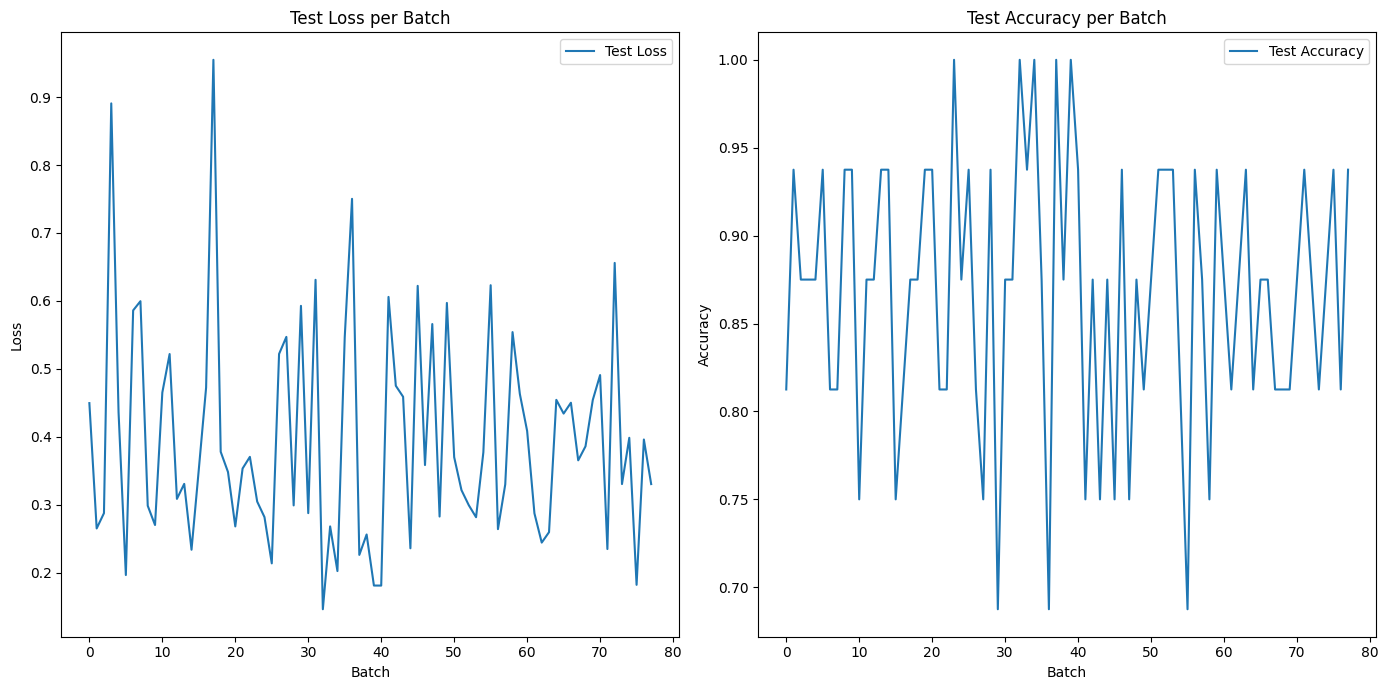

In [27]:
# Initialize lists to store loss and accuracy for each batch
test_losses = []
test_accuracies = []

# Loop through the test dataset and evaluate on each batch
for images, labels in test_dataset:
    # Compute loss and accuracy for the current batch
    batch_loss, batch_accuracy = model.evaluate(images, labels, verbose=0)
    test_losses.append(batch_loss)
    test_accuracies.append(batch_accuracy)

# Plot test loss and accuracy
batches = range(len(test_losses))

plt.figure(figsize=(14, 7))

# Plot test loss
plt.subplot(1, 2, 1)
plt.plot(batches, test_losses, label='Test Loss')
plt.title('Test Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

# Plot test accuracy
plt.subplot(1, 2, 2)
plt.plot(batches, test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

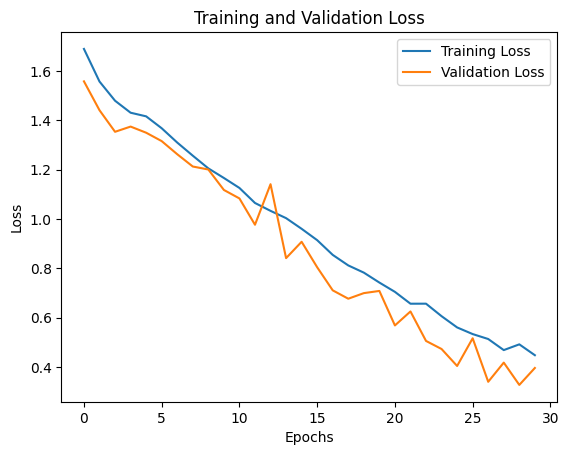

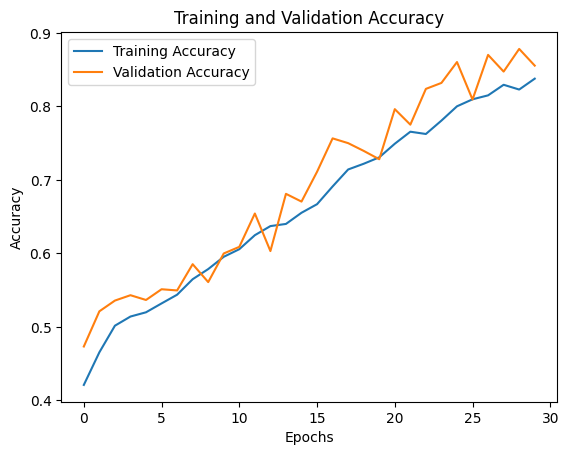

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━

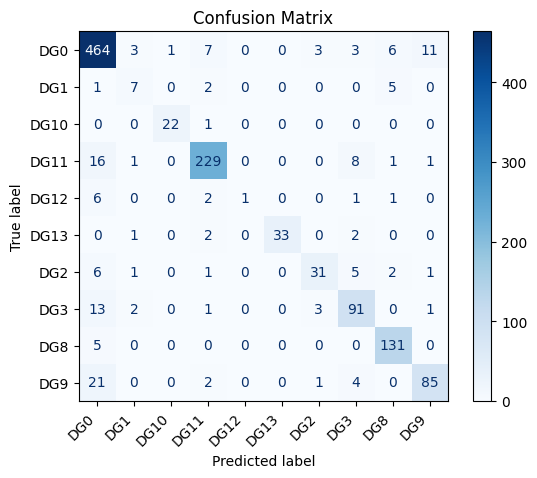

In [22]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Initialize lists for true and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the test dataset to get predictions and true labels
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    predicted_labels.extend(np.argmax(predictions, axis=1))  # Convert probabilities to class indices

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
cm_normalized = confusion_matrix(true_labels, predicted_labels, normalize='true')  # Normalized matrix

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix")
plt.show()


# Code used for Augmentation

In [ ]:
import os
from tensorflow.keras.utils import img_to_array, load_img  # Correct imports for TensorFlow 2.x
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
dataset_path = '/content/drive/MyDrive/dataset 3.0/data for train +test'
#augmented_path = '/content/drive/MyDrive/dataset 3.0/augmented_data2.0'      #UNCOMMENT THSI TO CREATE ANOTHER AUGMENTED FOLDER!
os.makedirs(augmented_path, exist_ok=True)

# Define augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=[0.85, 1.15],
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define categories based on DG codes
categories = ['DG0', 'DG1', 'DG10', 'DG11', 'DG12', 'DG13', 'DG2', 'DG3', 'DG8', 'DG9']

# Process images and perform augmentation
for img in os.listdir(dataset_path):
    try:
        # Extract DG code from the filename
        dg_code = img.split('_')[5]  # Assuming the 6th field in the filename corresponds to DG
        if dg_code in categories:
            # Ensure a subdirectory exists for the category
            save_dir = os.path.join(augmented_path, dg_code)
            os.makedirs(save_dir, exist_ok=True)

            # Load and preprocess the image
            image = load_img(os.path.join(dataset_path, img))  # Load the image
            x = img_to_array(image)  # Convert to array
            x = x.reshape((1,) + x.shape)  # Reshape for augmentation

            # Generate augmented images and save them
            i = 0
            for batch in datagen.flow(x, batch_size=1, save_to_dir=save_dir,
                                      save_prefix=dg_code, save_format='jpg'):
                i += 1
                if i > 2:  # Generate 25 augmented images per original image
                    break
    except Exception as e:
        print(f"Error processing image {img}: {e}")

print("Augmentation completed.")
